# Flexible Job Shop Scheduling

This notebook demonstrates how to model a **Flexible Job Shop Scheduling Problem (FJSP)**.

## Problem Description

The Flexible Job Shop extends the classical Job Shop:
- Each operation can be processed on **multiple alternative machines**
- Different machines may have **different processing times** for the same operation
- **Objective**: Select machines and schedule operations to minimize makespan

## Mathematical Model

**Sets**:
- $J$ = set of jobs
- $M$ = set of machines  
- $O_j$ = ordered operations of job $j$
- $M_{jo}$ = set of machines capable of processing operation $o$ of job $j$

**Parameters**:
- $p_{jom}$ = processing time of operation $o$ of job $j$ on machine $m$

**Variables**:
- $s_{jo}$ = start time of operation $o$ of job $j$
- $x_{jom}$ = 1 if operation $o$ of job $j$ is assigned to machine $m$

**Constraints**:
1. **Assignment**: Each operation assigned to exactly one capable machine
2. **Precedence**: Operations in a job processed in order
3. **No-overlap**: Operations on same machine don't overlap

In [1]:
# Imports
from pycsp3 import satisfy, minimize, solve, SAT, OPTIMUM, Maximum, clear
from pycsp3_scheduling import (
    IntervalVar, SequenceVar, SeqNoOverlap,
    alternative, end_before_start, end_time, interval_value,
    visu
)
from pycsp3_scheduling.variables.interval import clear_interval_registry

print("Imports successful!")

Imports successful!


## Problem Data

Each operation can be processed on multiple machines with different durations:

In [2]:
# Problem data
# processing_times[job][operation] = {machine: duration}
processing_times = [
    # Job 0
    [{0: 3, 1: 2}, {1: 4, 2: 3}, {0: 2, 2: 4}],
    # Job 1  
    [{0: 2, 2: 5}, {1: 3}, {0: 4, 1: 3, 2: 2}],
    # Job 2
    [{1: 3, 2: 2}, {0: 4, 1: 2}, {2: 3}],
]

n_jobs = len(processing_times)
n_machines = 3

print("Problem Instance:")
print(f"  Jobs: {n_jobs}")
print(f"  Machines: {n_machines}")
print()
for j, job in enumerate(processing_times):
    print(f"Job {j}:")
    for o, machines_dict in enumerate(job):
        opts = ", ".join(f"M{m}({d})" for m, d in machines_dict.items())
        print(f"  Op {o}: {opts}")

Problem Instance:
  Jobs: 3
  Machines: 3

Job 0:
  Op 0: M0(3), M1(2)
  Op 1: M1(4), M2(3)
  Op 2: M0(2), M2(4)
Job 1:
  Op 0: M0(2), M2(5)
  Op 1: M1(3)
  Op 2: M0(4), M1(3), M2(2)
Job 2:
  Op 0: M1(3), M2(2)
  Op 1: M0(4), M1(2)
  Op 2: M2(3)


## Building the Model

In [3]:
# Clear any previous model state
clear()
clear_interval_registry()

# Create main interval for each operation (machine not yet decided)
ops = []
for j, job in enumerate(processing_times):
    job_ops = []
    for o, machines_dict in enumerate(job):
        # Duration range from min to max across machines
        min_dur = min(machines_dict.values())
        max_dur = max(machines_dict.values())
        op = IntervalVar(size=(min_dur, max_dur), name=f"J{j}_O{o}")
        job_ops.append(op)
    ops.append(job_ops)

print("Main operation intervals (variable duration):")
for j, job_ops in enumerate(ops):
    for o, op in enumerate(job_ops):
        print(f"  {op.name}: size=[{op.size_min}, {op.size_max}]")

Main operation intervals (variable duration):
  J0_O0: size=[2, 3]
  J0_O1: size=[3, 4]
  J0_O2: size=[2, 4]
  J1_O0: size=[2, 5]
  J1_O1: size=[3, 3]
  J1_O2: size=[2, 4]
  J2_O0: size=[2, 3]
  J2_O1: size=[2, 4]
  J2_O2: size=[3, 3]


In [4]:
# Create optional alternatives for each (operation, machine) pair
alternatives = []  # alternatives[j][o] = list of (machine, interval) pairs
machine_ops = [[] for _ in range(n_machines)]  # Operations assigned to each machine

for j, job in enumerate(processing_times):
    job_alts = []
    for o, machines_dict in enumerate(job):
        op_alts = []
        for m, duration in machines_dict.items():
            alt = IntervalVar(
                size=duration,
                optional=True,
                name=f"J{j}_O{o}_M{m}"
            )
            op_alts.append((m, alt))
            machine_ops[m].append(alt)
        job_alts.append(op_alts)
    alternatives.append(job_alts)

print("Alternative intervals (optional):")
for j in range(n_jobs):
    for o in range(len(alternatives[j])):
        alts = [f"{alt.name}" for _, alt in alternatives[j][o]]
        print(f"  {ops[j][o].name} -> [{', '.join(alts)}]")

Alternative intervals (optional):
  J0_O0 -> [J0_O0_M0, J0_O0_M1]
  J0_O1 -> [J0_O1_M1, J0_O1_M2]
  J0_O2 -> [J0_O2_M0, J0_O2_M2]
  J1_O0 -> [J1_O0_M0, J1_O0_M2]
  J1_O1 -> [J1_O1_M1]
  J1_O2 -> [J1_O2_M0, J1_O2_M1, J1_O2_M2]
  J2_O0 -> [J2_O0_M1, J2_O0_M2]
  J2_O1 -> [J2_O1_M0, J2_O1_M1]
  J2_O2 -> [J2_O2_M2]


In [5]:
# Alternative constraints: select exactly one machine per operation
for j in range(n_jobs):
    for o in range(len(ops[j])):
        alt_intervals = [alt for _, alt in alternatives[j][o]]
        satisfy(alternative(ops[j][o], alt_intervals))

print("Alternative constraints added (select exactly one machine per operation)")

# Precedence within jobs
for j in range(n_jobs):
    for o in range(len(ops[j]) - 1):
        satisfy(end_before_start(ops[j][o], ops[j][o+1]))

print("Precedence constraints added")

# No-overlap on each machine
for m in range(n_machines):
    if machine_ops[m]:
        satisfy(SeqNoOverlap(machine_ops[m]))

print("No-overlap constraints added for each machine")

Alternative constraints added (select exactly one machine per operation)
Precedence constraints added
No-overlap constraints added for each machine


In [6]:
# Minimize makespan
last_ops = [ops[j][-1] for j in range(n_jobs)]
minimize(Maximum(end_time(op) for op in last_ops))

print("Objective: Minimize makespan")

Objective: Minimize makespan


## Solving

In [7]:
# Solve
result = solve()

if result in (SAT, OPTIMUM):
    print("Solution found!" + (" (Optimal)" if result == OPTIMUM else ""))
    print()
    
    for j in range(n_jobs):
        print(f"Job {j}:")
        for o in range(len(ops[j])):
            val = interval_value(ops[j][o])
            
            # Find which machine was selected
            selected_machine = None
            for m, alt in alternatives[j][o]:
                alt_result = interval_value(alt)
                if alt_result is not None:
                    selected_machine = m
                    break
            
            print(f"  Op {o}: Machine {selected_machine}, [{val.start}, {val.end}]")
    
    makespan = max(interval_value(ops[j][-1]).end for j in range(n_jobs))
    print(f"\nMakespan: {makespan}")
else:
    print("No solution found")

Solution found! (Optimal)

Job 0:
  Op 0: Machine 1, [0, 2]
  Op 1: Machine 2, [2, 5]
  Op 2: Machine 0, [6, 8]
Job 1:
  Op 0: Machine 0, [0, 2]
  Op 1: Machine 1, [2, 5]
  Op 2: Machine 1, [5, 8]
Job 2:
  Op 0: Machine 2, [0, 2]
  Op 1: Machine 0, [2, 6]
  Op 2: Machine 2, [6, 9]

Makespan: 9


## Visualization

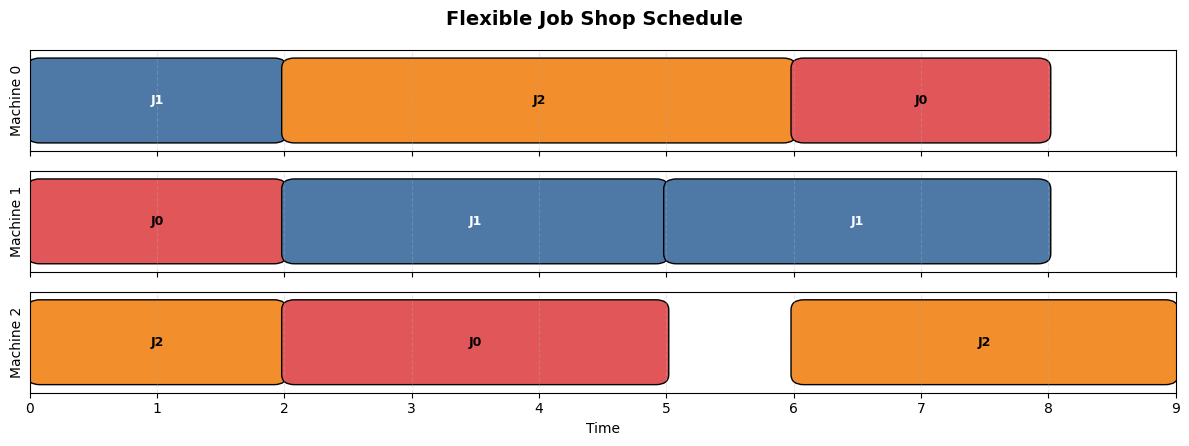

In [8]:
if result in (SAT, OPTIMUM):
    visu.reset()
    makespan = max(interval_value(ops[j][-1]).end for j in range(n_jobs))
    visu.timeline("Flexible Job Shop Schedule", origin=0, horizon=makespan)
    
    # Build schedule per machine from selected alternatives
    machine_schedule = {m: [] for m in range(n_machines)}
    
    for j in range(n_jobs):
        for o in range(len(alternatives[j])):
            for m, alt in alternatives[j][o]:
                alt_val = interval_value(alt)
                if alt_val is not None:  # This alternative was selected
                    machine_schedule[m].append((alt_val.start, alt_val.end, j, o))
    
    # Create panels for each machine
    for m in range(n_machines):
        visu.panel(f"Machine {m}")
        for start, end, j, o in sorted(machine_schedule[m]):
            visu.interval(start, end, f"J{j}", color=j)
    
    if visu.is_visu_enabled():
        visu.show()
    else:
        print("Visualization disabled (matplotlib not available)")
        print("\nMachine Schedules:")
        for m in range(n_machines):
            print(f"  Machine {m}: ", end="")
            for start, end, j, o in sorted(machine_schedule[m]):
                print(f"J{j}O{o}[{start},{end}] ", end="")
            print()

## Extension: Setup Times

When setup times depend on job types:

In [9]:
# Example setup time configuration (not applied to model above)
from pycsp3_scheduling import TransitionMatrix

job_types = [0, 1, 0]  # Type of each job

# Setup time matrix: time to switch from type i to type j
setup_matrix = TransitionMatrix([
    [0, 5, 3],  # From type 0
    [4, 0, 2],  # From type 1
    [3, 4, 0],  # From type 2
])

print("To use setup times:")
print("  1. Create SequenceVar with types for each machine")
print("  2. Use SeqNoOverlap(seq, transition_matrix=matrix)")
print(f"\nSetup time Type 0 -> Type 1: {setup_matrix[0, 1]}")

To use setup times:
  1. Create SequenceVar with types for each machine
  2. Use SeqNoOverlap(seq, transition_matrix=matrix)

Setup time Type 0 -> Type 1: 5


## Summary

This notebook demonstrated:

1. **Flexible assignments** using `alternative()` constraint
2. **Optional intervals** for machine choices
3. **Variable duration** based on machine selection

### Key Modeling Pattern

```python
# Main operation (abstract)
op = IntervalVar(size=(min_dur, max_dur), name="op")

# Machine alternatives (optional)
alt_m0 = IntervalVar(size=dur_m0, optional=True, name="op_m0")
alt_m1 = IntervalVar(size=dur_m1, optional=True, name="op_m1")

# Select exactly one
satisfy(alternative(op, [alt_m0, alt_m1]))
```